In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.model_selection import train_test_split


from utils.neural_network import (
    Embedding, Layer_Dense, Activation_ReLU, Loss_MeanSquaredError
)
from utils.optimizer import Optimizer_Adam
from utils.functions import calculate_metrics

# Data preparation

In [2]:
car_brands = [
    'audi', 'bmw', 'cclass', 'focus', 'ford',
    'hyundi', 'merc', 'skoda', 'toyota', 'vauxhall', 'vw'
]

datasets = []
for car in car_brands:
    df_car = pd.read_csv(f"data/{car}.csv")
    df_car["car_brand"] = car
    datasets.append(df_car)

full_df = pd.concat(datasets, ignore_index=True)

# Some CSVs have "tax(£)" instead of "tax"
if "tax(£)" in full_df.columns and "tax" not in full_df.columns:
    full_df = full_df.rename(columns={"tax(£)": "tax"})

# Keep only the columns we actually use
required_cols = [
    "model", "transmission", "fuelType", "car_brand",
    "year", "mileage", "tax", "mpg", "engineSize", "price"
]
full_df = full_df[required_cols]

# Clean NaNs / infinities
full_df = full_df.replace([np.inf, -np.inf], np.nan)
full_df = full_df.dropna(subset=required_cols)

In [3]:
cat_cols = ["model", "transmission", "fuelType", "car_brand"]
num_cols = ["year", "mileage", "tax", "mpg", "engineSize"]

# --- Label encode categoricals ---
label_encoders = {}
for col in cat_cols:
    full_df[col] = full_df[col].astype(str).str.strip()
    le = LabelEncoder()
    full_df[col] = le.fit_transform(full_df[col])
    label_encoders[col] = le

# --- Scale numeric features ---
x_scaler = StandardScaler()
full_df[num_cols] = x_scaler.fit_transform(full_df[num_cols])

# --- Scale target (price) ---
y_scaler = StandardScaler()
y = full_df["price"].values.reshape(-1, 1)
y = y_scaler.fit_transform(y)

# --- Prepare arrays ---
X_cat = full_df[cat_cols].astype(int).values
X_num = full_df[num_cols].values
n_samples = len(full_df)

# 70% train, 15% val, 15% test
X_cat_train, X_cat_temp, X_num_train, X_num_temp, y_train, y_temp = train_test_split(
    X_cat, X_num, y, test_size=0.3, random_state=42
)

X_cat_val, X_cat_test, X_num_val, X_num_test, y_val, y_test = train_test_split(
    X_cat_temp, X_num_temp, y_temp, test_size=0.5, random_state=42
)

n_train = len(X_cat_train)
n_val = len(X_cat_val)
n_test = len(X_cat_test)

print("Train:", n_train, "Val:", n_val, "Test:", n_test)


n_model = int(full_df["model"].max()) + 1
n_brand = int(full_df["car_brand"].max()) + 1
n_trans = int(full_df["transmission"].max()) + 1
n_fuel  = int(full_df["fuelType"].max()) + 1

print("n_model:", n_model, "n_brand:", n_brand, "n_trans:", n_trans, "n_fuel:", n_fuel)

Train: 66028 Val: 14149 Test: 14150
n_model: 179 n_brand: 8 n_trans: 4 n_fuel: 5


## Create layers


In [4]:
emb_model = Embedding(n_model, 16)
emb_brand = Embedding(n_brand, 8)
emb_trans = Embedding(n_trans, 4)
emb_fuel  = Embedding(n_fuel, 4)

# Infer dense input dim from TRAIN data
X_cat_sample = X_cat_train[:1]
X_num_sample = X_num_train[:1]

e1 = emb_model.forward(X_cat_sample[:, 0])
e2 = emb_brand.forward(X_cat_sample[:, 1])
e3 = emb_trans.forward(X_cat_sample[:, 2])
e4 = emb_fuel.forward(X_cat_sample[:, 3])

Xb_sample = np.concatenate([e1, e2, e3, e4, X_num_sample], axis=1)
dense_input_dim = Xb_sample.shape[1]
print("Dense input dim =", dense_input_dim)

dense1 = Layer_Dense(dense_input_dim, 128)
relu1  = Activation_ReLU()
dense2 = Layer_Dense(128, 64)
relu2  = Activation_ReLU()
dense3 = Layer_Dense(64, 1)

loss_fn = Loss_MeanSquaredError()
optimizer = Optimizer_Adam(learning_rate=3e-4)

Dense input dim = 37


## Training loop

In [6]:
epochs = 10
batch_size = 256

history = []  # will store metrics per epoch

for epoch in range(epochs):

    perm = np.random.permutation(n_train)
    X_cat_train = X_cat_train[perm]
    X_num_train = X_num_train[perm]
    y_train = y_train[perm]

    epoch_loss = 0.0

    for i in range(0, n_train, batch_size):
        X_cat_b = X_cat_train[i:i+batch_size]
        X_num_b = X_num_train[i:i+batch_size]
        y_b = y_train[i:i+batch_size]

        # ---- FORWARD ----
        e1 = emb_model.forward(X_cat_b[:, 0])
        e2 = emb_brand.forward(X_cat_b[:, 1])
        e3 = emb_trans.forward(X_cat_b[:, 2])
        e4 = emb_fuel.forward(X_cat_b[:, 3])

        Xb = np.concatenate([e1, e2, e3, e4, X_num_b], axis=1)

        dense1.forward(Xb)
        relu1.forward(dense1.output)
        dense2.forward(relu1.output)
        relu2.forward(dense2.output)
        dense3.forward(relu2.output)

        predictions = dense3.output
        loss = loss_fn.forward(predictions, y_b)
        epoch_loss += loss

        # ---- BACKWARD ----
        loss_fn.backward(predictions, y_b)
        dense3.backward(loss_fn.dinputs)
        relu2.backward(dense3.dinputs)
        dense2.backward(relu2.dinputs)
        relu1.backward(dense2.dinputs)
        dense1.backward(relu1.dinputs)

        # Embedding grads (first 32 dims = 16+8+4+4)
        dcat = dense1.dinputs[:, :32]
        emb_model.backward(dcat[:, 0:16])
        emb_brand.backward(dcat[:, 16:24])
        emb_trans.backward(dcat[:, 24:28])
        emb_fuel.backward(dcat[:, 28:32])

        # ---- OPTIMIZER ----
        optimizer.update_params(dense1)
        optimizer.update_params(dense2)
        optimizer.update_params(dense3)
        optimizer.update_params(emb_model)
        optimizer.update_params(emb_brand)
        optimizer.update_params(emb_trans)
        optimizer.update_params(emb_fuel)

        optimizer.post_update_params()

    # ---- VALIDATION FORWARD ----
    e1_val = emb_model.forward(X_cat_val[:, 0])
    e2_val = emb_brand.forward(X_cat_val[:, 1])
    e3_val = emb_trans.forward(X_cat_val[:, 2])
    e4_val = emb_fuel.forward(X_cat_val[:, 3])

    Xb_val = np.concatenate([e1_val, e2_val, e3_val, e4_val, X_num_val], axis=1)

    dense1.forward(Xb_val)
    relu1.forward(dense1.output)
    dense2.forward(relu1.output)
    relu2.forward(dense2.output)
    dense3.forward(relu2.output)

    val_pred_scaled = dense3.output
    val_true = y_scaler.inverse_transform(y_val)
    val_pred = y_scaler.inverse_transform(val_pred_scaled)

    print(f"Epoch {epoch+1}/{epochs} - Train Loss: {epoch_loss:.4f}")
    metrics = calculate_metrics(val_true, val_pred)  # returns dict

    # save in history
    history.append({
        "epoch": epoch + 1,
        "train_loss": epoch_loss,
        "val_mae": metrics["mae"],
        "val_mse": metrics["mse"],
        "val_mape": metrics["mape"],
    })

Epoch 1/10 - Train Loss: 16.0435
Epoch 2/10 - Train Loss: 15.7329
Epoch 2/10 - Train Loss: 15.7329
Epoch 3/10 - Train Loss: 15.6384
Epoch 3/10 - Train Loss: 15.6384
Epoch 4/10 - Train Loss: 15.2093
Epoch 4/10 - Train Loss: 15.2093
Epoch 5/10 - Train Loss: 15.1911
Epoch 5/10 - Train Loss: 15.1911
Epoch 6/10 - Train Loss: 14.8325
Epoch 6/10 - Train Loss: 14.8325
Epoch 7/10 - Train Loss: 14.5614
Epoch 7/10 - Train Loss: 14.5614
Epoch 8/10 - Train Loss: 14.2957
Epoch 8/10 - Train Loss: 14.2957
Epoch 9/10 - Train Loss: 14.2275
Epoch 9/10 - Train Loss: 14.2275
Epoch 10/10 - Train Loss: 14.1917
Epoch 10/10 - Train Loss: 14.1917


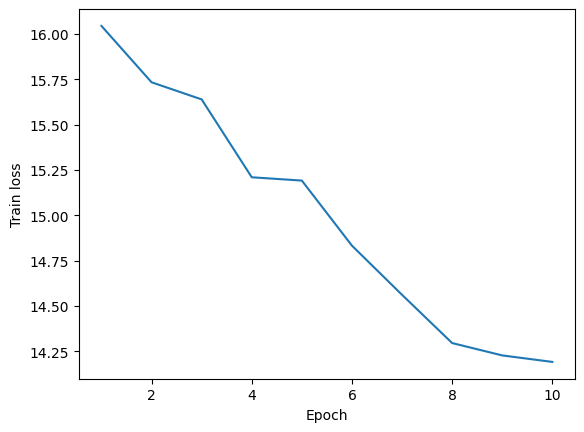

In [7]:
hist_df = pd.DataFrame(history)

plt.plot(hist_df["epoch"], hist_df["train_loss"])
plt.xlabel("Epoch")
plt.ylabel("Train loss")
plt.show()

In [22]:
e1_test = emb_model.forward(X_cat_test[:, 0])
e2_test = emb_brand.forward(X_cat_test[:, 1])
e3_test = emb_trans.forward(X_cat_test[:, 2])
e4_test = emb_fuel.forward(X_cat_test[:, 3])

Xb_test = np.concatenate([e1_test, e2_test, e3_test, e4_test, X_num_test], axis=1)

dense1.forward(Xb_test)
relu1.forward(dense1.output)
dense2.forward(relu1.output)
relu2.forward(dense2.output)
dense3.forward(relu2.output)

y_test_pred_scaled = dense3.output
y_test_true = y_scaler.inverse_transform(y_test)
y_test_pred = y_scaler.inverse_transform(y_test_pred_scaled)

print("\n=== FINAL TEST METRICS ===")
results = calculate_metrics(y_test_true, y_test_pred)
print(f"Mean absolute error (in pounds): {round(float(results.get('mae')),2)}")
print(f"Mean absolute percentage error {round(float(results.get('mape')),2)}")


=== FINAL TEST METRICS ===
Mean absolute error (in pounds): 1517.61
Mean absolute percentage error 10.43
